In [1]:
pip install mplsoccer

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# **1. Carregando Dados**

## **1.1 Importando bibliotecas**

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.io as pio
pio.templates.default = "seaborn"

from mplsoccer import (VerticalPitch, Pitch, create_transparent_cmap, FontManager, arrowhead_marker, Sbopen)

# Importando biblioteca para ocultar Future Warnings
import warnings
warnings.filterwarnings('ignore')

C:\Users\Vinicius De Andrade\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## **1.2 Criando funções auxiliares**

In [2]:
def remove_vs_entries(df, column_name):
    # Use str.startswith() to create a boolean mask
    mask = ~df[column_name].str.startswith('vs')

    # Apply the mask to filter out entries starting with 'vs'
    filtered_df = df[mask]

    return filtered_df

def remove_non_vs_entries(df, column_name):
    # Use str.startswith() to create a boolean mask
    mask = df[column_name].str.startswith('vs')

    # Apply the mask to filter out entries that do not start with 'vs'
    filtered_df = df[mask]

    return filtered_df

In [3]:
def barChart(data, x_axis, y_axis, n=None, color=None, color_dict=None):
  plot = data.sort_values(x_axis, ascending=False).head(n)
  plot = plot.sort_values(x_axis, ascending=True)

  fig = px.bar(plot, x=x_axis, y=y_axis, text=x_axis, color=color, color_discrete_map=color_dict)
  fig.update_layout(height=700, width=1000, yaxis={'categoryorder':'total ascending'})
  fig.add_vline(x=data[x_axis].mean(), line=dict(color="black", dash="dashdot", width=2))
  fig.show()

In [4]:
def scatter_chart(data, x_axis, y_axis, xtick_labels=None, ytick_labels=None, legenda=None, data_labels=None,
 color_dict=None, x_title=None, y_title=None, chart_title = None, axis=None, hline=None):

  if chart_title==None:
    chart_title=''
  else:
    chart_title=chart_title

  # Find the min and max for each axis
  min_axis = min([
      min(data[x_axis]*1.1),
      min(data[y_axis]*1.1)
    ])
  max_axis = max([
      max(data[x_axis]*1.1),
      max(data[y_axis]*1.1)
    ])

  # colors
  if color_dict==None:
    n_colors = len(data['teams'])
    colors = px.colors.sample_colorscale("RdYlGn", [n/(n_colors -1) for n in range(n_colors)])
    fig = px.scatter(data, x=x_axis, y=y_axis, color=legenda, text=data_labels, color_discrete_sequence=colors)

  else:
    fig = px.scatter(data, x=x_axis, y=y_axis, color=legenda, text=data_labels, color_discrete_map=color_dict)

  fig.update_traces(textposition='middle right',marker_size=10)

  if axis==True:
    fig.update_layout(
          xaxis=dict(
          range = [min_axis, max_axis],
          tickvals = x_axis,
          title = x_title
      ),
      yaxis=dict(
          range = [min_axis, max_axis],
          title = y_title
      ),
        title=dict(
            text=chart_title,
            font=dict(size=20),
            yref='paper'
      ),height=800,
        width=1500
    )

  else:
    fig.update_layout(
        xaxis=dict(
          range = [min(data[x_axis]*0.9), max(data[x_axis]*1.1)],
          title = x_title,
      ),
        yaxis=dict(
          range = [min(data[y_axis]*0.9), max(data[y_axis]*1.1)],
          title = y_title
      ),
        title=dict(
            text=chart_title,
            font=dict(size=20),
            yref='container'
      ),height=800,
        width=1500
    )

  if hline==True:
    fig.add_hline(y=data[y_axis].mean(), line=dict(color="black", dash="dashdot", width=1))
    fig.add_vline(x=data[x_axis].mean(), line=dict(color="black", dash="dashdot", width=1))


  else:
    fig.add_hline(y=0, line=dict(color="black", dash="dashdot", width=1))
    fig.add_vline(x=0, line=dict(color="black", dash="dashdot", width=1))

  fig.show()

In [5]:
def pitch_plot(team_data, list_cols):
  # setup a mplsoccer pitch
  pitch = Pitch(line_zorder=2, line_color='black', pad_top=20)

  # mplsoccer calculates the binned statistics usually from raw locations, such as touches events
  # for this example we will create a binned statistic dividing
  # the pitch into thirds for one point (0, 0)
  # we will fill this in a loop later with each team's statistics from the dataframe
  bin_statistic = pitch.bin_statistic([0], [0], statistic='count', bins=(3, 1))

  GRID_HEIGHT = 0.8
  CBAR_WIDTH = 0.03
  fig, axs = pitch.grid(nrows=4, ncols=5, figheight=20,
                        # leaves some space on the right hand side for the colorbar
                        grid_width=0.88, left=0.025,
                        endnote_height=0.03, endnote_space=0,
                        # Turn off the endnote/title axis. I usually do this after
                        # I am happy with the chart layout and text placement
                        axis=False,
                        title_space=0.02, title_height=0.06, grid_height=GRID_HEIGHT)
  fig.set_facecolor('white')
  #touches_cols = ['Def 3rd_Touches','Mid 3rd_Touches', 'Att 3rd_Touches']

  data = remove_vs_entries(team_data, 'Squad')
  data[list_cols] = data[list_cols].divide(data[list_cols].sum(axis=1), axis=0) * 100.
  data.sort_values([list_cols[2], list_cols[0]], ascending=[True, False], inplace=True)

  # a FontManager object for using a google font (default Robotto)
  fm = FontManager()
  # path effects

  teams = data['Squad'].values
  vmin = data[list_cols].min().min()  # we normalise the heatmaps with the min / max values
  vmax = data[list_cols].max().max()
  for i, ax in enumerate(axs['pitch'].flat[:len(teams)]):
      # the top of the pitch is zero
      # plot the title half way between zero and -20 (the top padding)
      ax.text(60, -10, f'{teams[i]}\n Def ------ Mid ------ Atk',
              ha='center', va='center', fontsize=30,
              fontproperties=fm.prop)

      # fill in the bin statistics from df and plot the heatmap
      bin_statistic['statistic'] = data.loc[team_data.Squad == teams[i], list_cols].values
      heatmap = pitch.heatmap(bin_statistic, ax=ax, cmap='coolwarm', vmin=vmin, vmax=vmax)
      annotate = pitch.label_heatmap(bin_statistic, color='white', fontproperties=fm.prop, fontsize=30, ax=ax,
                                    str_format='{0:.0f}%', ha='center', va='center')

  # if its the Bundesliga remove the two spare pitches
  if len(teams) == 18:
      for ax in axs['pitch'][-1, 3:]:
          ax.remove()

  # add cbar axes
  cbar_bottom = axs['pitch'][-1, 0].get_position().y0
  cbar_left = axs['pitch'][0, -1].get_position().x1 + 0.01
  ax_cbar = fig.add_axes((cbar_left, cbar_bottom, CBAR_WIDTH,
                          # take a little bit off the height because of padding
                          GRID_HEIGHT - 0.036))
  cbar = plt.colorbar(heatmap, cax=ax_cbar)
  for label in cbar.ax.get_yticklabels():
      label.set_fontproperties(fm.prop)
      label.set_fontsize(20)

  # title and endnote
  title = axs['title'].text(0.5, 0.5, 'Touches %, Campeonato Brasileiro, 2023',
                            ha='center', va='center', fontsize=50)

## **1.3 Carregando datasets**

In [6]:
siglas = {
    'América (MG)' : 'AMG',
    'Bahia' : 'BAH',
    'Botafogo (RJ)' : 'BOT',
    'Atlético Mineiro' : 'CAM',
    'Ath Paranaense' : 'CAP',
    'Corinthians' : 'COR',
    'Cruzeiro' : 'CRU',
    'Flamengo' : 'FLA',
    'Fluminense' : 'FLU',
    'Grêmio' : 'GRE',
    'Internacional' : 'INT',
    'Palmeiras' : 'PAL',
    'Santos' : 'SAN',
    'São Paulo' : 'SAO',
    'Vasco da Gama' : 'VAS',
    'Bragantino' : 'RBB',
    'Coritiba' : 'CFC',
    'Cuiabá' : 'CUI',
    'Fortaleza' : 'FOR',
    'Goiás' : 'GOI'
    }

siglas_vs = {
    'vs América (MG)' : 'vsAMG',
    'vs Bahia' : 'vsBAH',
    'vs Botafogo (RJ)' : 'vsBOT',
    'vs Atlético Mineiro' : 'vsCAM',
    'vs Ath Paranaense' : 'vsCAP',
    'vs Corinthians' : 'vsCOR',
    'vs Cruzeiro' : 'vsCRU',
    'vs Flamengo' : 'vsFLA',
    'vs Fluminense' : 'vsFLU',
    'vs Grêmio' : 'vsGRE',
    'vs Internacional' : 'vsINT',
    'vs Palmeiras' : 'vsPAL',
    'vs Santos' : 'vsSAN',
    'vs São Paulo' : 'vsSAO',
    'vs Vasco da Gama' : 'vsVAS',
    'vs Bragantino' : 'vsRBB',
    'vs Coritiba' : 'vsCFC',
    'vs Cuiabá' : 'vsCUI',
    'vs Fortaleza' : 'vsFOR',
    'vs Goiás' : 'vsGOI'
    }

Headed_Goals = {
    'América (MG)' : 7,
    'Bahia' : 5,
    'Botafogo (RJ)' : 12,
    'Atlético Mineiro' : 4,
    'Ath Paranaense' : 14,
    'Corinthians' : 11,
    'Cruzeiro' : 7,
    'Flamengo' : 14,
    'Fluminense' : 8,
    'Grêmio' : 7,
    'Internacional' : 3,
    'Palmeiras' : 18,
    'Santos' : 5,
    'São Paulo' : 6,
    'Vasco da Gama' : 13,
    'Bragantino' : 7,
    'Coritiba' : 8,
    'Cuiabá' : 10,
    'Fortaleza' : 6,
    'Goiás' : 13
    }

# Loading datasets
team_std = pd.read_csv(f'standard_team.csv', index_col="Unnamed: 0")
team_pass = pd.read_csv(f'passing_team.csv', index_col="Unnamed: 0")
team_shoot = pd.read_csv(f'shooting_team.csv', index_col="Unnamed: 0")
team_def = pd.read_csv(f'defense_team.csv', index_col="Unnamed: 0")
team_time = pd.read_csv(f'playing_time_team.csv', index_col="Unnamed: 0")
team_pass_type = pd.read_csv(f'passing_types_team.csv', index_col="Unnamed: 0")
team_poss = pd.read_csv(f'possession_team.csv', index_col="Unnamed: 0")
team_goal_shot = pd.read_csv(f'goal_shot_creation_team.csv', index_col="Unnamed: 0")
team_keeper = pd.read_csv(f'keeper_team.csv', index_col="Unnamed: 0")
team_keeper_adv = pd.read_csv(f'keeper_adv_team.csv', index_col="Unnamed: 0")
league_table_home_away = pd.read_csv(f'league_table_home_away_team.csv', index_col="Unnamed: 0")
league_table = pd.read_csv(f'league_table_team.csv', index_col="Unnamed: 0")
team_misc = pd.read_csv(f'misc_team.csv', index_col="Unnamed: 0")

In [7]:
# Merging Datasets
atk = team_pass.merge(team_shoot, how='outer').merge(
    team_goal_shot, how='outer').merge(team_poss, how='outer').merge(team_pass_type, how='outer').merge(team_misc, how='outer').merge(league_table, how='outer')

atk.drop(columns=['Competition_Name', 'Gender', 'Country', 'Season_End_Year', 'Team_or_Opponent', 'Num_Players',	'Mins_Per_90'], inplace=True)



# **2. ATTACK ANALYSIS**

## **COLUMNS**

In [8]:
atk = remove_vs_entries(atk, 'Squad')
atk['teams'] = atk['Squad'].replace(siglas)
atk['Headed Goals'] = atk['Squad'].replace(Headed_Goals)

In [9]:
atk['Headed Goals %'] = ((atk['Headed Goals']/atk['Gls_Standard'])*100).round(2)
atk['Headed Goals per 90'] = atk['Headed Goals']/atk['MP']

atk['Goals per 90'] = atk['Gls_Standard']/atk['MP']

atk['Shots Attempts per 90'] = atk['Sh_Standard']/atk['MP']

atk['Touches in Penalty Area per 90'] = atk['Att Pen_Touches']/atk['MP']
atk['Crosses into the Penalty Area per 90'] = atk['CrsPA']/atk['MP']

atk['Deep Completions per 90'] = atk['PPA']/atk['MP']
atk['Deep Completions Acuracy %'] = (atk['PPA']/atk['Crs'])*100

atk['Crosses Acuracy %'] = (atk['CrsPA']/atk['Crs'])*100
atk['Crosses per 90'] = atk['Crs']/atk['MP']

atk['Through Balls per 90'] = atk['TB_Pass_Types']/atk['MP']
atk['Passes to Final Third per 90'] = atk['Final_Third']/atk['MP']

atk['Long Passes Attempts per 90'] = atk['Att_Long']/atk['MP']
atk['Passes Attempts per 90'] = atk['Att_Total']/atk['MP']

atk['PASSES TO PA'] = atk['PPA']+atk['CrsPA']
atk['TO PA'] = atk['PPA']+atk['CrsPA']+atk['CPA_Carries']
atk['Carries to Penalty Area per 90'] = atk['CPA_Carries']/atk['MP']
atk['Passes to Penalty Area per 90'] = atk['PASSES TO PA']/atk['MP']
atk['Touches to Penalty Area per 90'] = atk['TO PA']/atk['MP']

atk['Shot-Creating Actions by Dead Ball per 90'] = atk['PassDead_SCA_Types']/atk['MP']
atk['Shot-Creating Actions by Live Ball per 90'] = atk['PassLive_SCA_Types']/atk['MP']
atk['Shot-Creating Actions by Dribling per 90'] = atk['TO_SCA_Types']/atk['MP']

atk['Dribling attempts per 90'] = atk['Att_Take_Ons']/atk['MP']
atk['Success Dribling per 90'] = atk['Succ_Take_Ons']/atk['MP']
atk['Dribling Success % per 90'] =(atk['Success Dribling per 90']/atk['Dribling attempts per 90'])*100
atk['Carries to Penalty Area per 90'] = atk['CPA_Carries']/atk['MP']

atk['Progressive Passes per 100 Touches'] = ((atk['PrgP']/ atk['Touches_Touches']) * 100).round(2)
atk['Passes progressivos a cada 100 Toques na bola'] = ((atk['PrgP']/ atk['Touches_Touches']) * 100).round(2)
atk['Progressive Carries per 100 Touches'] = ((atk['PrgC_Carries']/ atk['Touches_Touches']) * 100).round(2)
atk['Progressões individuais a cada 100 Toques na bola'] = ((atk['PrgC_Carries']/ atk['Touches_Touches']) * 100).round(2)

In [13]:
list(atk.columns)

['Squad',
 'Cmp_Total',
 'Att_Total',
 'Cmp_percent_Total',
 'TotDist_Total',
 'PrgDist_Total',
 'Cmp_Short',
 'Att_Short',
 'Cmp_percent_Short',
 'Cmp_Medium',
 'Att_Medium',
 'Cmp_percent_Medium',
 'Cmp_Long',
 'Att_Long',
 'Cmp_percent_Long',
 'Ast',
 'xAG',
 'xA_Expected',
 'A_minus_xAG_Expected',
 'KP',
 'Final_Third',
 'PPA',
 'CrsPA',
 'PrgP',
 'Gls_Standard',
 'Sh_Standard',
 'SoT_Standard',
 'SoT_percent_Standard',
 'Sh_per_90_Standard',
 'SoT_per_90_Standard',
 'G_per_Sh_Standard',
 'G_per_SoT_Standard',
 'Dist_Standard',
 'FK_Standard',
 'PK_Standard',
 'PKatt_Standard',
 'xG_Expected',
 'npxG_Expected',
 'npxG_per_Sh_Expected',
 'G_minus_xG_Expected',
 'np:G_minus_xG_Expected',
 'SCA_SCA',
 'SCA90_SCA',
 'PassLive_SCA_Types',
 'PassDead_SCA_Types',
 'TO_SCA_Types',
 'Sh_SCA_Types',
 'Fld_SCA_Types',
 'Def_SCA_Types',
 'GCA_GCA',
 'GCA90_GCA',
 'PassLive_GCA_Types',
 'PassDead_GCA_Types',
 'TO_GCA_Types',
 'Sh_GCA_Types',
 'Fld_GCA_Types',
 'Def_GCA_Types',
 'Poss',
 'Touche

In [24]:
plot_gols = atk.sort_values('GF', ascending=True)
plot_ast = atk.sort_values('Ast', ascending=True)
fig = make_subplots(rows=1, cols=2, subplot_titles=('Gols a Favor', 'Assistências'))

fig.add_trace(
    go.Bar(x=plot_gols['GF'], y=plot_gols["Squad"], text=plot_gols['GF'], orientation='h', name='Gols a Favor', marker_color='green'),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=plot_ast['Ast'], y=plot_ast["Squad"], text=plot_ast['Ast'], orientation= 'h', name='Assistências', marker_color='red'),
    row=1, col=2
)

fig.update_layout(height=700, width=1800, title_text="Side By Side Subplots")

fig.show()

## **xG vs xAG**

In [12]:
atk_teams = atk.sort_values(by='Gls_Standard', ascending=True).reset_index(drop=True)

scatter_chart(atk_teams, 'Ast', 'Gls_Standard', legenda='Squad', data_labels='teams', x_title='A S S I S T S', hline=True, y_title='G O A L S')

In [13]:
atk_teams = atk.sort_values(by='xG_Expected', ascending=True).reset_index(drop=True)

scatter_chart(atk_teams, 'xAG', 'xG_Expected', legenda='Squad', data_labels='teams',
 x_title='xAG', hline=True, y_title='xG')

In [14]:
atk_teams = atk.sort_values(by='G_minus_xG_Expected', ascending=True).reset_index(drop=True)

scatter_chart(atk_teams, 'A_minus_xAG_Expected', 'G_minus_xG_Expected', legenda='Squad', data_labels='teams',
 x_title='ASSISTS - xAG', y_title='GOALS - xG')

In [15]:
atk_teams = atk.sort_values(by='xG_Expected', ascending=False).reset_index(drop=True)
atk_teams[['xG', 'xAG', 'A-xAG', 'G-xG','Gols marcados']] = atk_teams[['xG_Expected', 'xAG', 'A_minus_xAG_Expected', 'G_minus_xG_Expected','Gls_Standard']]

atk_teams[['Squad', 'xG', 'xAG', 'A-xAG', 'G-xG','Gols marcados']]

,Squad,xG,xAG,A-xAG,G-xG,Gols marcados
0,Bragantino,57.8,39.1,-9.1,-9.8,48
1,Palmeiras,57.1,42.9,1.1,4.9,62
2,Fortaleza,51.4,34.9,-5.9,-7.4,44
3,Ath Paranaense,51.1,38.9,-0.9,-0.1,51
4,Bahia,50.6,31.8,-3.8,-2.6,48
5,Fluminense,50.3,36.4,-0.4,0.7,51
6,Botafogo (RJ),50.2,33.2,6.8,5.8,56
7,Grêmio,50.0,36.3,8.7,11.0,61
8,Flamengo,49.8,34.1,4.9,5.2,55
9,São Paulo,49.0,32.7,-5.7,-9.0,40


## **POSSE DE BOLA**

HTTPError: HTTP Error 404: Not Found

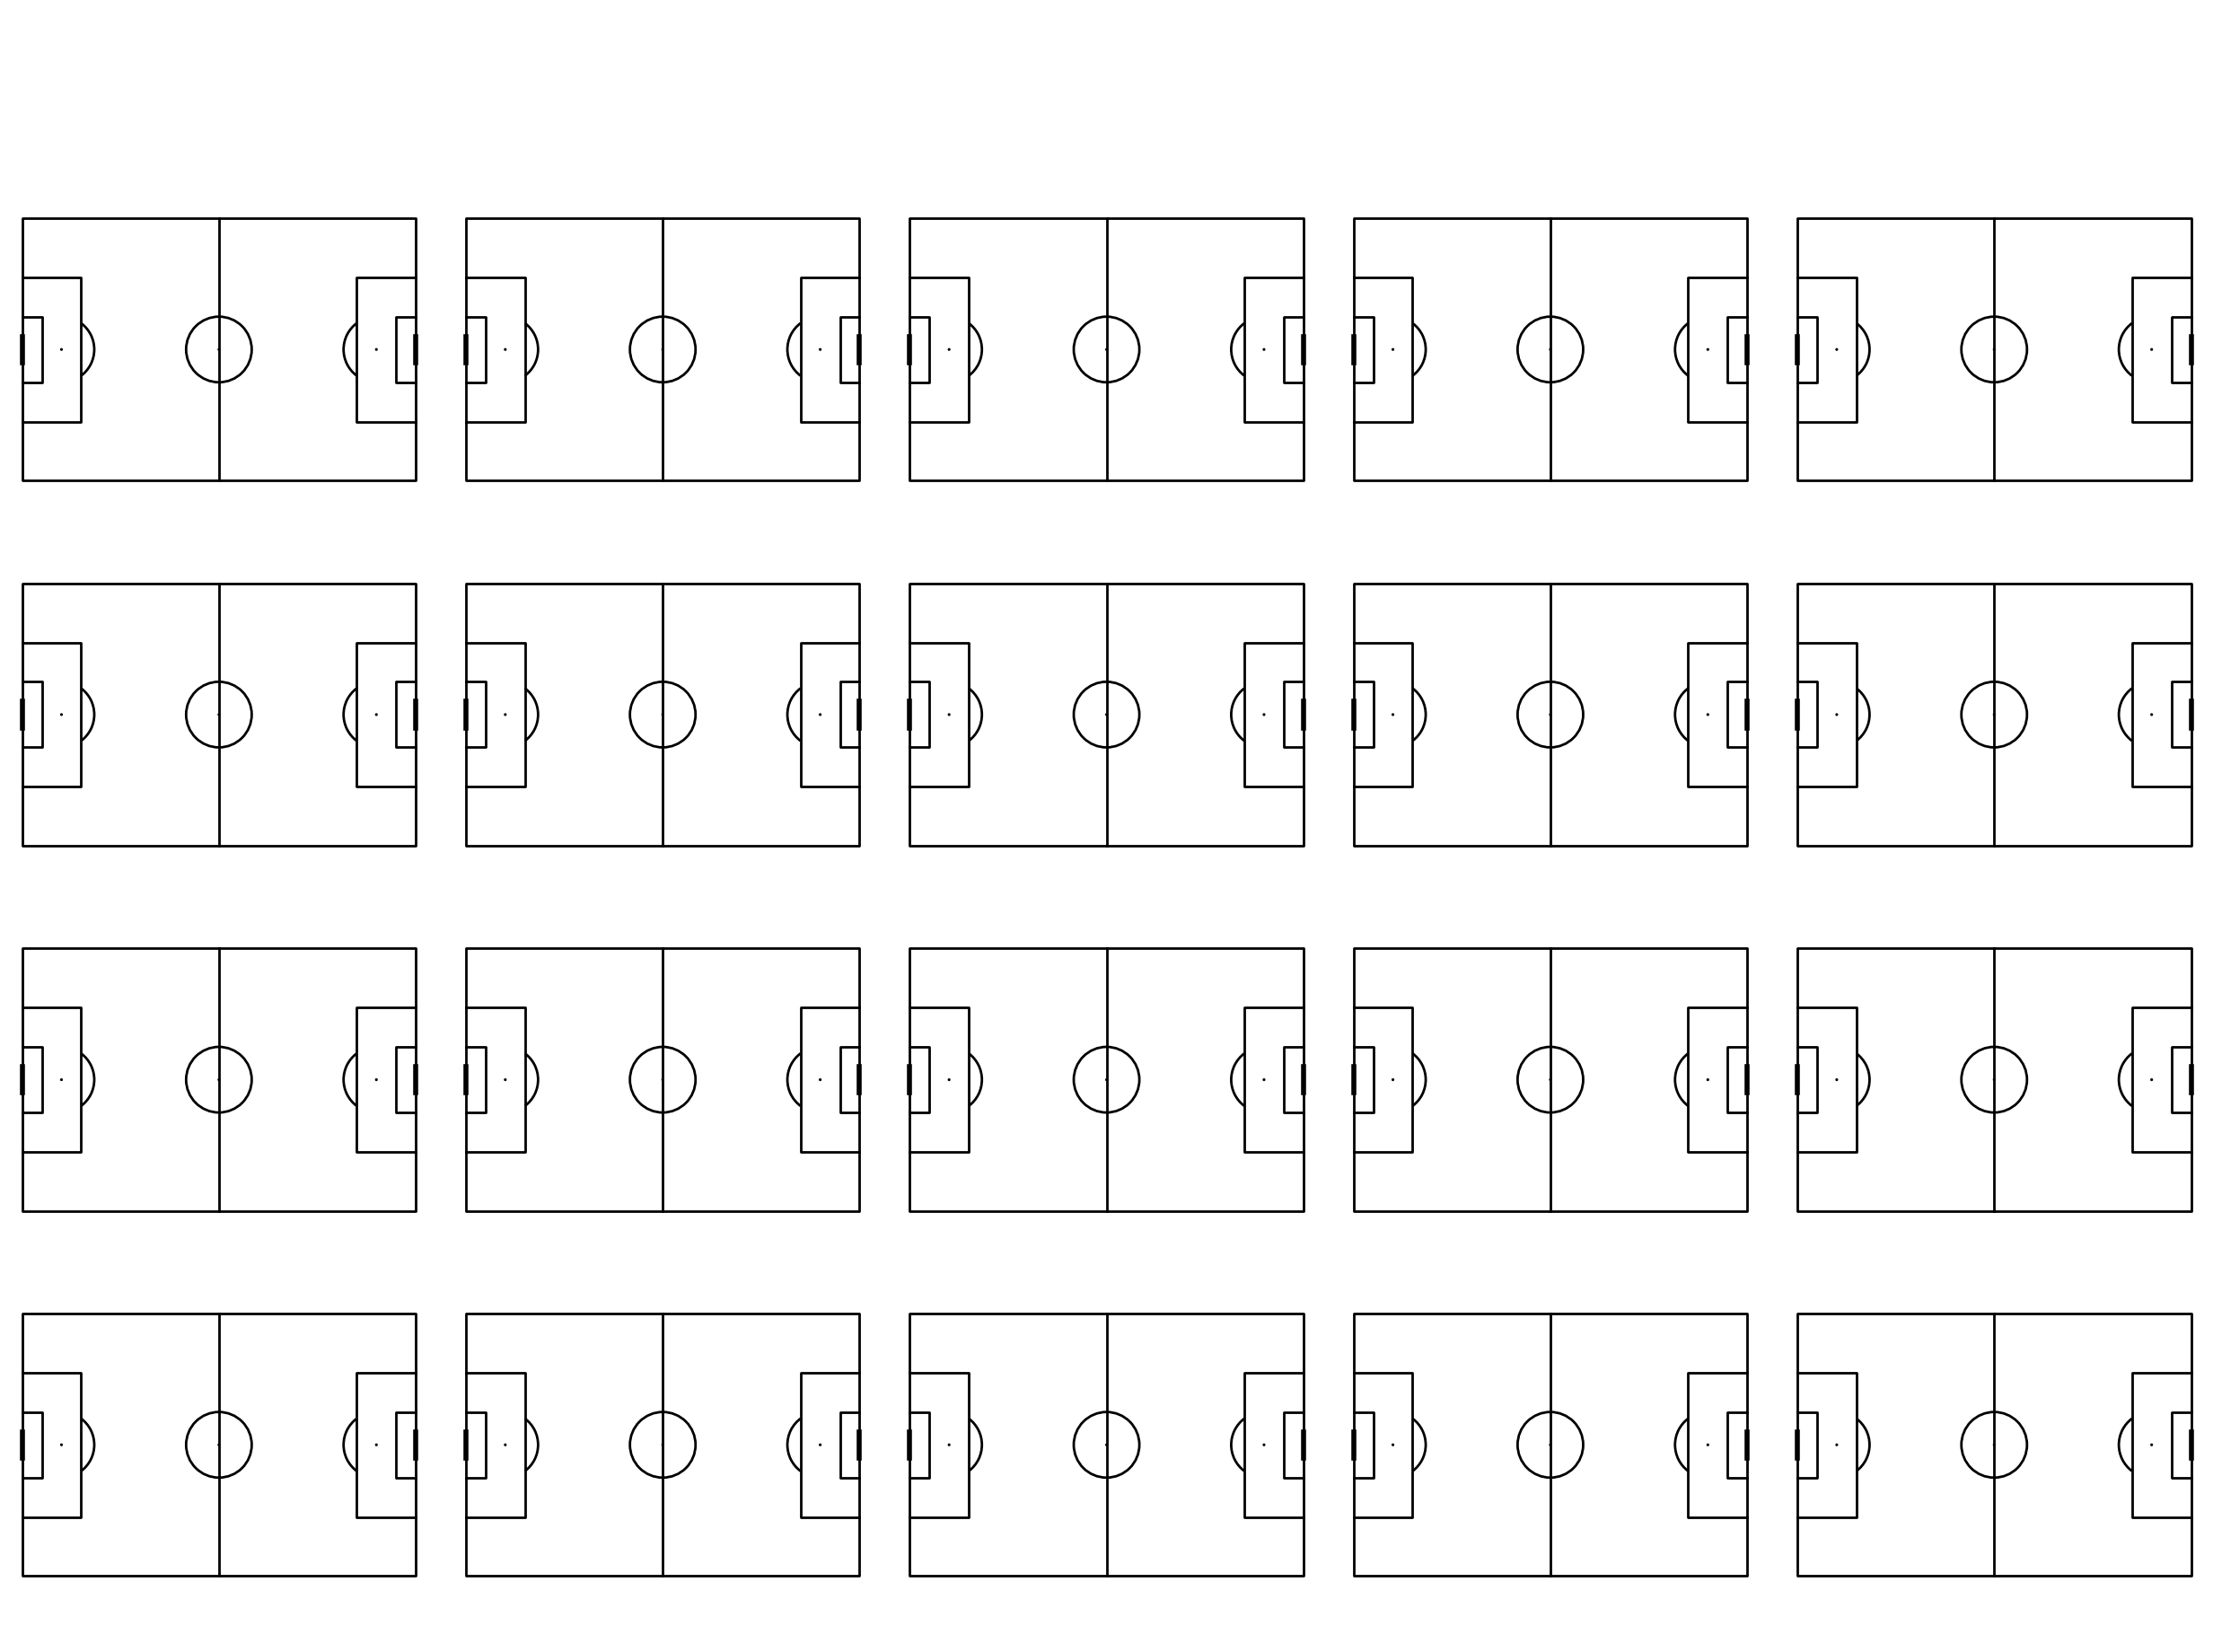

In [16]:
pitch_plot(atk, ['Def 3rd_Touches','Mid 3rd_Touches', 'Att 3rd_Touches'])

In [ ]:
posse = remove_vs_entries(atk, 'Squad')
posse[['Def 3rd_Touches','Mid 3rd_Touches', 'Att 3rd_Touches']] = posse[['Def 3rd_Touches','Mid 3rd_Touches', 'Att 3rd_Touches']].divide(posse[['Def 3rd_Touches','Mid 3rd_Touches', 'Att 3rd_Touches']].sum(axis=1), axis=0) * 100.
posse['diferençaDef'] = (posse['Att 3rd_Touches']+posse['Mid 3rd_Touches'])-posse['Def 3rd_Touches']
posse['diferençaMid'] = (posse['Def 3rd_Touches']+posse['Att 3rd_Touches'])-posse['Mid 3rd_Touches']
posse['diferençaAtt'] = (posse['Def 3rd_Touches']+posse['Mid 3rd_Touches'])-posse['Att 3rd_Touches']
posse.sort_values(by='diferençaAtt', ascending=True, inplace=True)

posse[['Squad','Def 3rd_Touches','Mid 3rd_Touches', 'Att 3rd_Touches','diferençaDef', 'diferençaMid', 'diferençaAtt' ]]

,Squad,Def 3rd_Touches,Mid 3rd_Touches,Att 3rd_Touches,diferençaDef,diferençaMid,diferençaAtt
5,Bragantino,24.866725,44.897788,30.235487,50.266549,10.204424,39.529027
14,Grêmio,27.058337,45.800579,27.141084,45.883326,8.398842,45.717832
10,Flamengo,26.147143,47.532197,26.320660,47.705715,4.935606,47.358680
8,Cruzeiro,28.674967,45.842597,25.482437,42.650067,8.314807,49.035127
0,América (MG),30.860549,44.189541,24.949910,38.278902,11.620918,50.100180
16,Palmeiras,29.013756,46.068020,24.918224,41.972487,7.863960,50.163552
11,Fluminense,32.045387,43.751854,24.202759,35.909226,12.496292,51.594482
3,Bahia,29.571280,46.253791,24.174929,40.857440,7.492417,51.650143
12,Fortaleza,27.125096,48.853123,24.021781,45.749807,2.293755,51.956438
17,Santos,31.186017,44.998752,23.815231,37.627965,10.002497,52.369538


## **SHOTS**

In [17]:
atk_teams = atk.sort_values(by='SoT_percent_Standard', ascending=True).reset_index(drop=True)

scatter_chart(atk_teams,  'Shots Attempts per 90', 'SoT_percent_Standard', legenda='teams', data_labels='teams',
 y_title='CHUTES NO ALVO %', x_title='CHUTES POR JOGO', hline=True)

In [18]:
atk_teams = atk.sort_values(by='Goals per 90', ascending=True).reset_index(drop=True)

scatter_chart(atk_teams,  'Shots Attempts per 90', 'Goals per 90', legenda='teams', data_labels='teams',
 y_title='GOLS POR JOGO', x_title='CHUTES POR JOGO', hline=True)

In [19]:
atk_teams = atk.sort_values(by='Shots Attempts per 90', ascending=True).reset_index(drop=True)
atk_teams['Shots Attempts per 90'] = atk_teams['Shots Attempts per 90']*0.9144

scatter_chart(atk_teams, 'Dist_Standard', 'Shots Attempts per 90', legenda='teams', data_labels='teams',
 x_title='DISTÂNCIA MÉDIA (m)', y_title='CHUTES POR JOGO', hline=True)

In [20]:
posse[['Squad','Dist_Standard', 'Shots Attempts per 90', 'Goals per 90', 'SoT_percent_Standard']]

NameError: name 'posse' is not defined

## **BUILD UP & CREATION**

### **OVERALL**

In [21]:
atk_teams = atk.sort_values(by='Touches in Penalty Area per 90', ascending=True).reset_index(drop=True)

scatter_chart(atk_teams, 'Touches to Penalty Area per 90', 'Touches in Penalty Area per 90', legenda='teams', data_labels='teams',
 x_title='Ações (passes e progressões individuais) para a área /90' , hline=True, y_title='Toques na bola dentro da área /90')

In [22]:
atk_teams = atk.sort_values(by='Touches in Penalty Area per 90', ascending=True).reset_index(drop=True)

scatter_chart(atk_teams, 'Passes to Penalty Area per 90', 'Carries to Penalty Area per 90', legenda='teams', data_labels='teams',
 x_title='Passes (cruzamentos e passes diretos) para a área /90' , hline=True, y_title='Progressões individuais para a área /90')

In [23]:
atk_teams = atk.sort_values(by='Touches in Penalty Area per 90', ascending=True).reset_index(drop=True)

scatter_chart(atk_teams, 'Deep Completions per 90', 'Crosses into the Penalty Area per 90', legenda='teams',  data_labels='teams',
 x_title='Passes diretos para a área /90' , hline=True, y_title='Cruzamentos para a área /90')

In [24]:
atk_teams = atk.sort_values(by='Att_Total', ascending=True).reset_index(drop=True)

scatter_chart(atk_teams, 'Passes Attempts per 90', 'Long Passes Attempts per 90', legenda='teams', data_labels='teams',
 x_title='Passes Tentados /90' , hline=True, y_title='Passes longos Tentados /90')

In [25]:
barChart(atk, 'Passes progressivos a cada 100 Toques na bola', 'Squad')

In [69]:
atk_teams['Passes Totais - Tentativas por jogo'] = atk_teams['Att_Total']/atk_teams['MP']
atk_teams['Passes Curtos - Tentativas por jogo'] = atk_teams['Att_Short']/atk_teams['MP']
atk_teams = atk_teams.sort_values(by='Passes Curtos - Tentativas por jogo', ascending=True).reset_index(drop=True)

fig = px.bar(atk_teams, y="Squad", x=['Passes Curtos - Tentativas por jogo', 'Passes Totais - Tentativas por jogo'], barmode = 'stack')
fig.update_layout(height = 600, width = 800)
fig.add_vline(x=atk_teams['Passes Totais - Tentativas por jogo'].mean(), line=dict(color="black", dash="dashdot", width=1))
fig.show()

In [82]:
atk_teams['Posse de Bola %'] = atk_teams['Poss']
atk_teams = atk_teams.sort_values(by='Posse de Bola %', ascending=False).reset_index(drop=True)
barChart(atk_teams, 'Posse de Bola %', 'Squad')


## **TAKE ONS**

In [26]:
atk_teams = atk.sort_values(by='Succ_percent_Take_Ons', ascending=True).reset_index(drop=True)

scatter_chart(atk_teams, 'Dribling attempts per 90', 'Dribling Success % per 90', legenda='teams', data_labels='teams',
 x_title='Dribling attempts per 90' , hline=True, y_title='Dribling Success % per 90')

In [53]:
atk_teams = atk.sort_values(by='Shot-Creating Actions by Dribling per 90', ascending=True).reset_index(drop=True)

scatter_chart(atk_teams, 'Dribling attempts per 90' , 'Shot-Creating Actions by Dribling per 90', legenda='teams', data_labels='teams',
 x_title='Tentativas de drible por jogo' , hline=True, y_title='SCA através de jogadas individuais por jogo')

In [28]:
barChart(atk, 'Progressões individuais a cada 100 Toques na bola', 'Squad')

## **CROSSES**

In [45]:
plot = atk.sort_values('Gls_Standard', ascending=False)
plot = plot.sort_values('Gls_Standard', ascending=True)


fig = make_subplots(rows=1, cols=3, subplot_titles=('Gols de cabeça',  'Gols de cabeça %'))
fig.add_trace(
    go.Bar(x=plot['Headed Goals'], y=plot["Squad"], text=plot['Headed Goals'], orientation='h', name='Gols a Favor', marker_color='green'),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=plot['Headed Goals %'], y=plot["Squad"], text=plot['Headed Goals %'], orientation='h', name='Saldo de Gols', marker_color="blue"),
    row=1, col=2
)

fig.update_layout(height=700, width=1800)
fig.show()

In [48]:
atk_teams = atk.sort_values(by='Headed Goals', ascending=True).reset_index(drop=True)

scatter_chart(atk_teams, 'Crosses per 90', 'Crosses Acuracy %', legenda='teams', data_labels='teams',
 x_title='Cruzamentos por jogo' , hline=True, y_title='Precisão nos Cruzamentos %')

In [50]:
atk_teams = atk.sort_values(by='Headed Goals', ascending=True).reset_index(drop=True)

scatter_chart(atk_teams, 'Crosses per 90', 'Headed Goals per 90', legenda='teams', data_labels='teams',
 x_title='Cruzamentos por jogo' , hline=True, y_title='Gols de Cabeça por jogo')

In [51]:
atk_teams = atk.sort_values(by='Shot-Creating Actions by Dead Ball per 90', ascending=True).reset_index(drop=True)

scatter_chart(atk_teams, 'Shot-Creating Actions by Dead Ball per 90', 'Headed Goals per 90', legenda='teams', data_labels='teams',
 x_title='Shot-Creating Actions by Dead Ball per 90' , hline=True, y_title='Headed Goals per 90')

- SURPREENDENTEMENTE JUNTO DO PALMEIRAS OS TIMES DO VASCO E AMERICA MG CONSEGUEM COMPLETAR DIVERSOS PASSES PARA DENTRO DA AREA

- CUIABA APESAR DE VENCER MUITOS DUELOS AEREOS, NÃO CRUZA BOLA NA AREA ADVERSARIA

- BOTAFOGO, ATHLETICO PARANAENSE E CORITIBA SÃO MUITO EFICIENTES EM SEUS POUCOS CRUZAMENTOS

- CRUZEIRO, CUIABA E BRAGANTINO SÃO OS TIMES MAIS INEFICIENTES EM RELAÇAO A CRUZAMENTOS CERTOS/ERRADOS

## **DEEP COMPLETIONS**

In [80]:
atk_teams = atk.sort_values(by='Through Balls per 90', ascending=True).reset_index(drop=True)

scatter_chart(atk_teams, 'Passes to Final Third per 90', 'Through Balls per 90', legenda='teams', data_labels='teams',
 x_title='Passes para o Terço Final por jogo' , hline=True, y_title='Passes em Profundidade por jogo')

## **CLUSTERMAP 1**

In [34]:
atk_heatmap = atk[['Squad', 'Pts','G_minus_xG_Expected', 'Headed Goals',
 'Headed Goals %',
 'Headed Goals per 90',
 'Shots Attempts per 90',
 'Touches in Penalty Area per 90',
 'Crosses into the Penalty Area per 90',
 'Deep Completions per 90',
 'Deep Completions Acuracy %',
 'Crosses Acuracy %',
 'Crosses per 90',
 'Through Balls per 90',
 'Passes to Final Third per 90',
 'Long Passes Attempts per 90',
 'Passes Attempts per 90',
 'PASSES TO PA',
 'Passes to Penalty Area per 90',
 'Dribling attempts per 90',
 'Success Dribling per 90',
 'Dribling Success % per 90',
 'Carries to Penalty Area per 90',
 'Goals per 90',
 'Shot-Creating Actions by Dead Ball per 90',
 'Shot-Creating Actions by Live Ball per 90',
 'Shot-Creating Actions by Dribling per 90',
 'Progressive Passes per 100 Touches',
       'Progressive Carries per 100 Touches']]

atk_heatmap = atk_heatmap.groupby('Squad').max().reset_index().set_index('Squad').sort_values('Pts', ascending=False)
atk_heatmap = atk_heatmap[['G_minus_xG_Expected', 'Headed Goals',
 'Headed Goals %',
 'Headed Goals per 90',
 'Shots Attempts per 90',
 'Touches in Penalty Area per 90',
 'Crosses into the Penalty Area per 90',
 'Deep Completions per 90',
 'Deep Completions Acuracy %',
 'Crosses Acuracy %',
 'Crosses per 90',
 'Through Balls per 90',
 'Passes to Final Third per 90',
 'Long Passes Attempts per 90',
 'Passes Attempts per 90',
 'PASSES TO PA',
 'Passes to Penalty Area per 90',
 'Dribling attempts per 90',
 'Success Dribling per 90',
 'Dribling Success % per 90',
 'Carries to Penalty Area per 90',
 'Goals per 90',
 'Shot-Creating Actions by Dead Ball per 90',
 'Shot-Creating Actions by Live Ball per 90',
 'Shot-Creating Actions by Dribling per 90','Progressive Passes per 100 Touches',
       'Progressive Carries per 100 Touches']]



### **SCIKIT**

In [35]:
from sklearn.preprocessing import StandardScaler, normalize
scaled_features = StandardScaler().fit_transform(atk_heatmap.values)
scaled_features_df = pd.DataFrame(scaled_features, index=atk_heatmap.index, columns=atk_heatmap.columns)
fig = px.imshow(scaled_features_df,color_continuous_scale='RdBu' , aspect="auto")
fig.show()

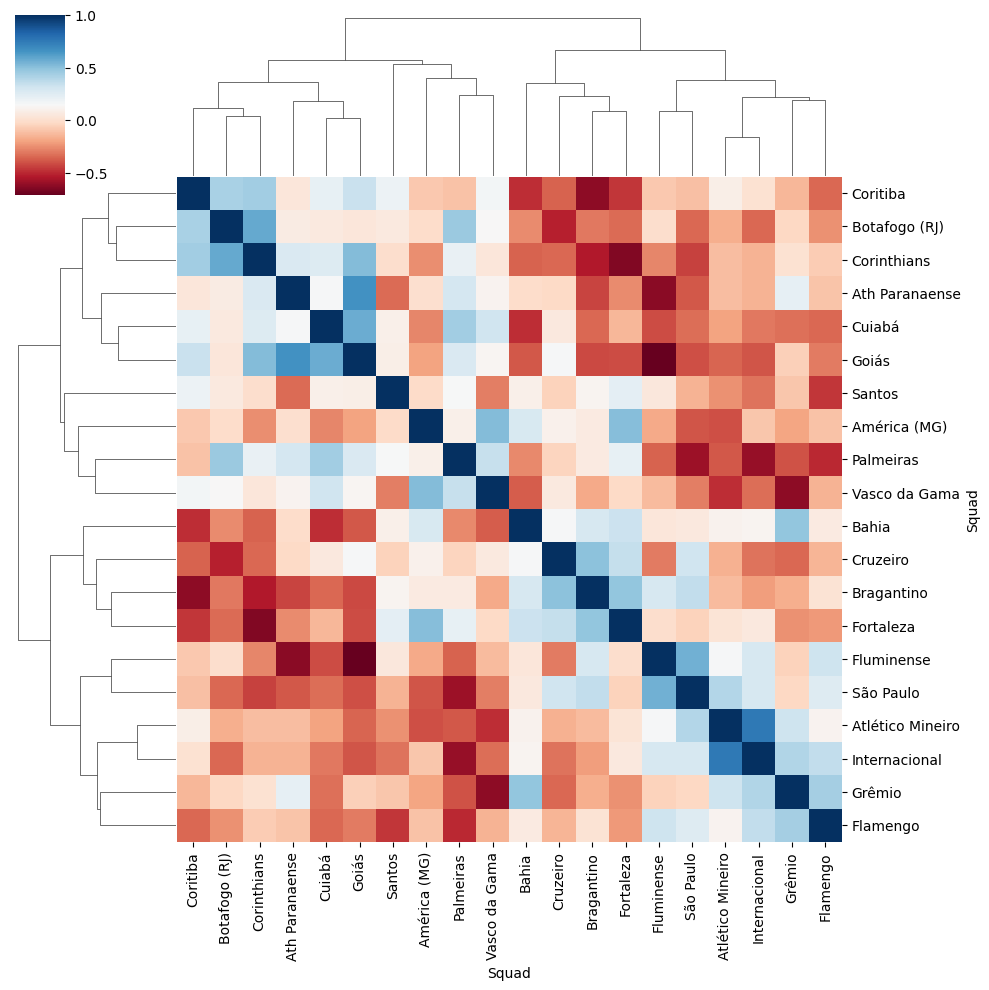

In [36]:
corr_df=(scaled_features_df.T.corr())
sns.clustermap(corr_df, cmap='RdBu')

### **NORMAL**

In [37]:
df_norm_col = (atk_heatmap-atk_heatmap.mean())/atk_heatmap.std()
fig = px.imshow(df_norm_col,color_continuous_scale='RdBu' , aspect="auto")
fig.show()

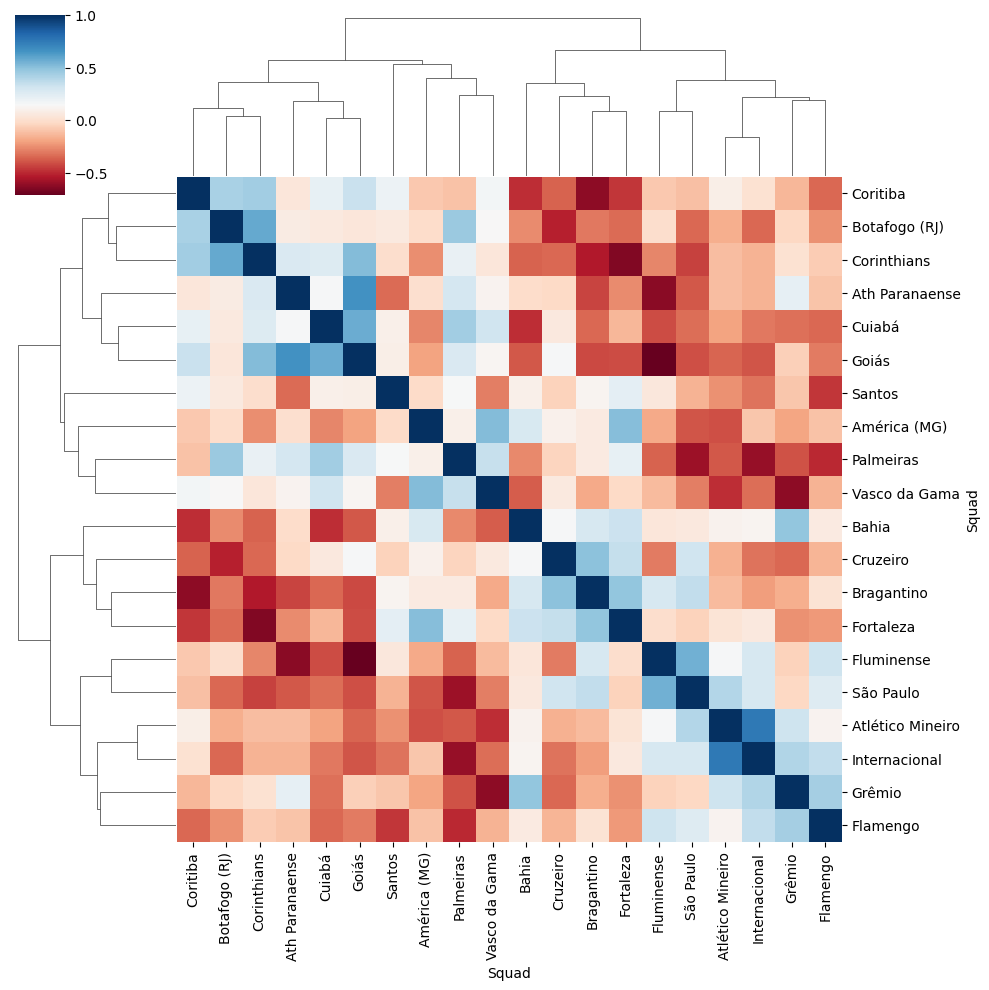

In [38]:
corr_df=(df_norm_col.T.corr())
sns.clustermap(corr_df, cmap='RdBu')

# **CLUSTERMAP 2**

In [39]:
atk_heatmap = atk[['Squad', 'Pts','G_minus_xG_Expected', 'Headed Goals',
 'Headed Goals %',
 'Headed Goals per 90',
 'Shots Attempts per 90',
 'Touches in Penalty Area per 90',
 'Crosses into the Penalty Area per 90',
 'Deep Completions per 90',
 'Deep Completions Acuracy %',
 'Crosses Acuracy %',
 'Crosses per 90',
 'Through Balls per 90',
 'Passes to Final Third per 90',
 'Long Passes Attempts per 90',
 'Passes Attempts per 90',
 'PASSES TO PA',
 'Passes to Penalty Area per 90',
 'Dribling attempts per 90',
 'Success Dribling per 90',
 'Dribling Success % per 90',
 'Carries to Penalty Area per 90',
 'Goals per 90',
 'Shot-Creating Actions by Dead Ball per 90',
 'Shot-Creating Actions by Live Ball per 90',
 'Shot-Creating Actions by Dribling per 90','Progressive Passes per 100 Touches',
       'Progressive Carries per 100 Touches']]

atk_heatmap = atk_heatmap.groupby('Squad').max().reset_index().set_index('Squad').sort_values('Pts', ascending=False)
atk_heatmap = atk_heatmap[['G_minus_xG_Expected', 'Headed Goals',
 'Headed Goals %',
 'Headed Goals per 90',
 'Shots Attempts per 90',
 'Touches in Penalty Area per 90',
 'Crosses into the Penalty Area per 90',
 'Deep Completions per 90',
 'Deep Completions Acuracy %',
 'Crosses Acuracy %',
 'Crosses per 90',
 'Through Balls per 90',
 'Passes to Final Third per 90',
 'Long Passes Attempts per 90',
 'Passes Attempts per 90',
 'PASSES TO PA',
 'Passes to Penalty Area per 90',
 'Dribling attempts per 90',
 'Success Dribling per 90',
 'Dribling Success % per 90',
 'Carries to Penalty Area per 90',
 'Goals per 90',
 'Shot-Creating Actions by Dead Ball per 90',
 'Shot-Creating Actions by Live Ball per 90',
 'Shot-Creating Actions by Dribling per 90','Progressive Passes per 100 Touches',
       'Progressive Carries per 100 Touches']]

### **scikit**

In [40]:
scaled_features_df = pd.DataFrame(scaled_features, index=atk_heatmap.index, columns=atk_heatmap.columns)
fig = px.imshow(scaled_features_df,color_continuous_scale='RdBu' , aspect="auto")
fig.show()

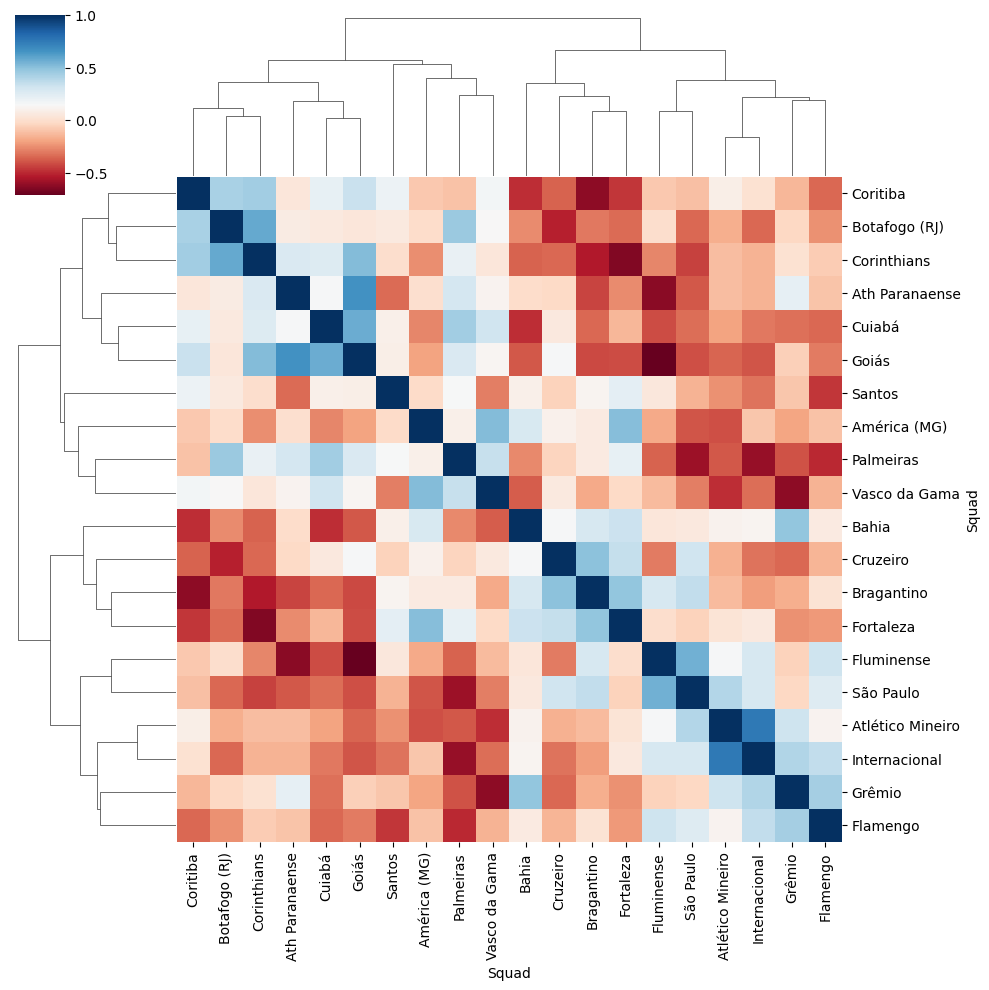

In [41]:
corr_df=(scaled_features_df.T.corr())
sns.clustermap(corr_df, cmap='RdBu')

### **NORMAL**

In [42]:
df_norm_col = (atk_heatmap-atk_heatmap.mean())/atk_heatmap.std()
fig = px.imshow(df_norm_col,color_continuous_scale='RdBu' , aspect="auto")
fig.show()

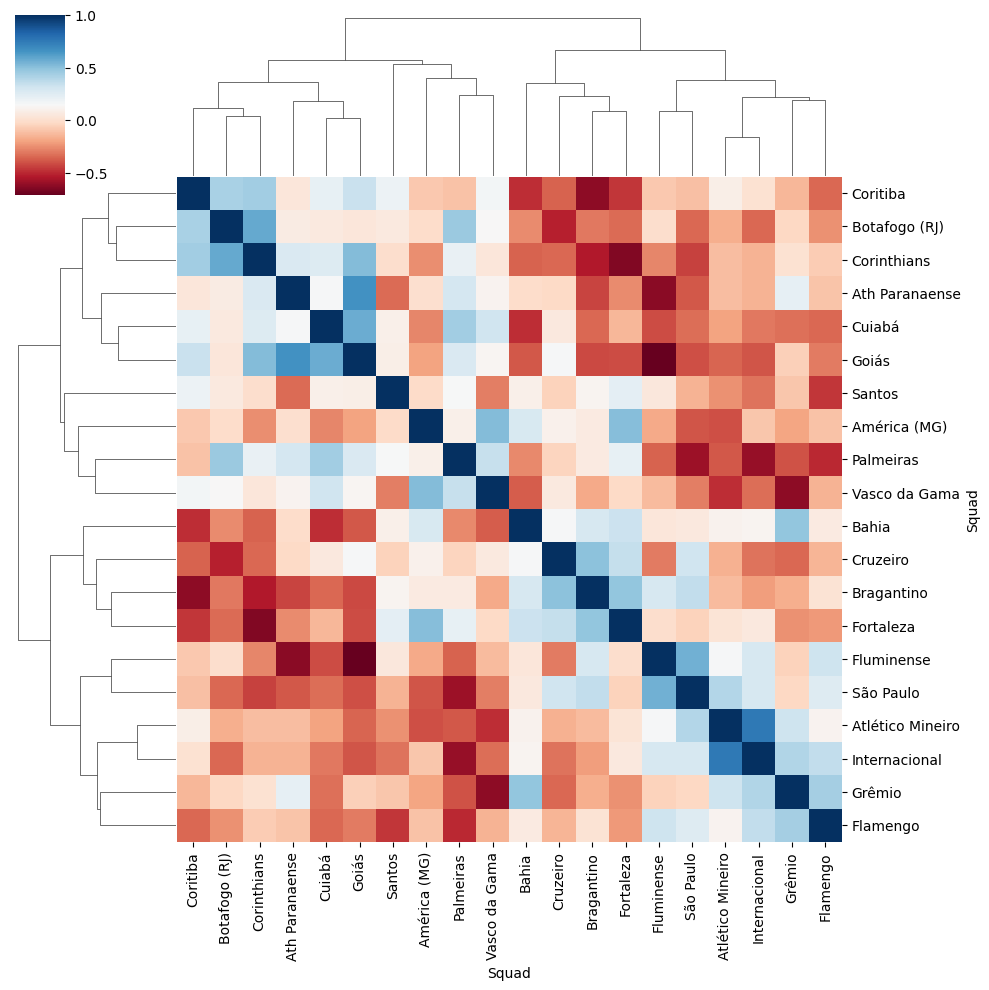

In [43]:
corr_df=(df_norm_col.T.corr())
sns.clustermap(corr_df, cmap='RdBu')

# **CONCLUSÕES**

- BRAGANTINO CRIA MUITAS CHANCES MAS NÃO FINALIZA BEM
  - SAO PAULO E AMERICA MG TAMBEM

- FLUMINENSE PARECE AVANÇAR O CAMPO ATRAVÉS DE PROGRESSOES INDIVIDUAIS E NÃO COM PASSES PARA FRENTE

- FLAMENGO AVANÇA ATRAVÉS DE PASSES